In [2]:
from flax import linen as nn, struct
from flax.training.train_state import TrainState
from jax.flatten_util import ravel_pytree
from optax import (
    softmax_cross_entropy_with_integer_labels as xent
)
import jax
import jax.numpy as jnp
import optax


class MLP(nn.Module):
    hidden_sizes: tuple[int, ...]
    out_features: int

    @nn.compact
    def __call__(self, x):
        for feat in self.hidden_sizes:
            scale = feat ** -0.5
            bias_init = nn.initializers.normal(stddev=scale)

            x = nn.Dense(feat, bias_init=bias_init)(x)
            x = nn.gelu(x)

        x = nn.Dense(self.out_features, bias_init=bias_init)(x)
        return x


@struct.dataclass
class TrainConfig:
    batch_size: int = 64
    num_epochs: int = 25

    opt: str = "sgd"


def make_apply_full(model, unraveler):
    """Make an apply function that takes the full parameter vector."""
    def apply_full(raveled, x):
        params = unraveler(raveled)
        return model.apply(params, x)
    
    return apply_full


def make_apply_subspace(model, unraveler, params0, basis):
    """Make an apply function that takes a small parameter vector."""
    def apply_subspace(small_params, x):
        raveled = params0 + basis.T @ small_params
        return model.apply(unraveler(raveled), x)
    
    return apply_subspace


# Loss function
def compute_loss(params, apply_fn, X, Y):
    logits = apply_fn(params['p'], X)
    preds = jnp.argmax(logits, axis=-1)

    loss = xent(logits, Y).mean()
    acc = jnp.mean(preds == Y)
    return loss, acc


def train(params, x_train, y_train, x_test, y_test, apply_fn, cfg: TrainConfig):
    # Create the batches
    X_batched = jnp.reshape(x_train, (-1, cfg.batch_size, 64))
    Y_batched = jnp.reshape(y_train, (-1, cfg.batch_size))

    # LR schedule
    num_steps = cfg.num_epochs * len(x_train) // cfg.batch_size

    # Define the optimizer and training state
    if cfg.opt == "adam":
        sched = optax.cosine_decay_schedule(3e-3, num_steps)
        tx = optax.adam(learning_rate=sched, eps_root=1e-8)
    else:
        sched = optax.cosine_decay_schedule(0.1, num_steps)
        tx = optax.chain(
            optax.sgd(learning_rate=sched, momentum=0.9)
        )

    state = TrainState.create(apply_fn=apply_fn, params=dict(p=params), tx=tx)

    # Forward and backward pass
    loss_and_grad = jax.value_and_grad(compute_loss, has_aux=True)

    def train_step(state: TrainState, batch):
        loss, grads = loss_and_grad(state.params, state.apply_fn, *batch)
        return state.apply_gradients(grads=grads), loss

    def epoch_step(state: TrainState, epoch) -> tuple[TrainState, tuple[jnp.ndarray, jnp.ndarray]]:
        state, (losses, accs) = jax.lax.scan(train_step, state, (X_batched, Y_batched))
        return state, (losses.mean(), accs.mean())

    state, (train_loss, _) = jax.lax.scan(epoch_step, state, jnp.arange(cfg.num_epochs))
    raveled, _ = ravel_pytree(state.params)

    # Test loss
    logits = state.apply_fn(state.params['p'], x_test)
    test_loss = xent(logits, y_test).mean()
    return raveled, test_loss#, train_loss # test_loss, train_loss[-1]


# grad_fn = jax.value_and_grad(train, has_aux=True)
jac_fn = jax.jacfwd(train, has_aux=True)

In [3]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split


# Load data
X, Y = load_digits(return_X_y=True)
X = X / 16.0  # Normalize

# Split data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=197, random_state=0)
spectra = []

d_inner = X.shape[1]

model = MLP(hidden_sizes=(d_inner,), out_features=10)

# Do a single run with seed 0 to get the Jac
key = jax.random.key(0)

params_0 = model.init(key, X_train)
raveled_0, unraveler = ravel_pytree(params_0)
apply_fn = make_apply_full(model, unraveler)

raveled_f, loss = train(raveled_0, X_train, Y_train, X_test, Y_test, apply_fn, TrainConfig(opt="sgd"))
params_f = unraveler(raveled_f)

params_0, unravel = ravel_pytree(params_0)
jac, losses = jac_fn(raveled_0, X_train, Y_train, X_test, Y_test, apply_fn, TrainConfig(opt="sgd"))
jac_u, jac_s, jac_vh = jnp.linalg.svd(jac)

2024-12-11 08:59:34.264035: W external/xla/xla/service/gpu/ir_emitter_unnested.cc:1171] Unable to parse backend config for custom call: Could not convert JSON string to proto: Expected : between key:value pair.
= true, full_matrice
^
Fall back to parse the raw backend config str.


## Plotting the spectrum

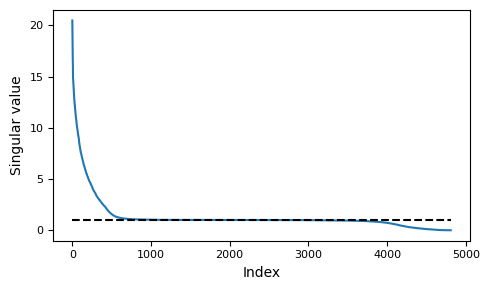

In [27]:
import matplotlib.pyplot as plt

# Define general parameters for plot suitable for LaTeX paper
plt.figure(figsize=(5, 3))  # Adjust figure size to be more paper-friendly
plt.rc('font', size=10)         # Default text size
plt.rc('axes', titlesize=12)    # Title font size
plt.rc('axes', labelsize=10)    # X and Y label size
plt.rc('xtick', labelsize=8)    # X tick label size
plt.rc('ytick', labelsize=8)    # Y tick label size
plt.rc('legend', fontsize=10)   # Legend font size
plt.rc('lines', linewidth=1.5)  # Line width for better visibility in print

# Your plot code
plt.plot(jac_s)
plt.hlines(1.0, 0, len(jac_s), linestyles="--", colors="black")

# Set axis labels with appropriate sizes
plt.xlabel("Index")
plt.ylabel("Singular value")

# Tight layout to ensure no clipping
plt.tight_layout()

# Show or save the plot
plt.savefig('jac spec.pdf', format='pdf')
plt.show()


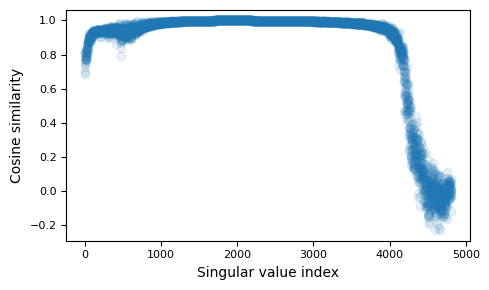

In [28]:
# alignment between left and right singular vectors
sims = jnp.einsum("ij,ji->j", jac_u, jac_vh)

plt.figure(figsize=(5, 3))  # Adjust figure size to be more paper-friendly
plt.scatter(jnp.arange(len(sims)), sims, alpha=0.1)

plt.xlabel("Singular value index")
plt.ylabel("Cosine similarity")

# Tight layout to ensure no clipping
plt.tight_layout()

# Show or save the plot
plt.savefig('cos sims.pdf', format='pdf')
plt.show()

## Finite differences

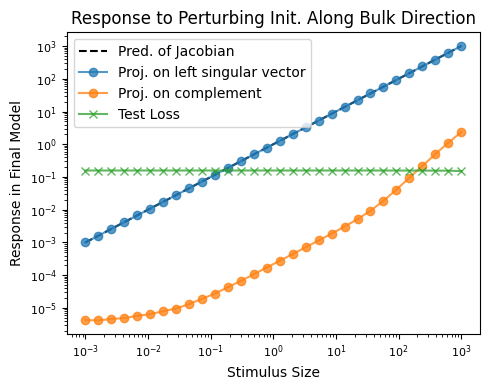

In [36]:
import matplotlib.pyplot as plt

complements = []
bulk_y = []
responses = []

params_f, loss = train(
    params_0, X_train, Y_train, X_test, Y_test, apply_fn, TrainConfig(opt="sgd")
)

num = 2000
grid = jnp.logspace(-3, 3, 30)
for stim in grid:
    perturbed_params, loss = train(
        params_0 + stim * jac_vh[num], X_train, Y_train, X_test, Y_test, apply_fn, TrainConfig(opt="sgd")
    )
    delta = perturbed_params - params_f
    res = delta @ jac_u[:, num]
    complement = jnp.linalg.norm(delta - res * jac_u[:, num])

    complements.append(complement)
    bulk_y.append(loss)
    responses.append(res)


plt.figure(figsize=(5, 4))  # Adjust figure size to be more paper-friendly
plt.plot(grid, grid * jac_s[num], label="Pred. of Jacobian", c="black", linestyle="--")
plt.plot(grid, jnp.abs(jnp.array(responses)), marker="o", label="Proj. on left singular vector", alpha=0.75)
plt.plot(grid, complements, marker="o", label="Proj. on complement", alpha=0.75)
plt.plot(grid, bulk_y, marker="x", label="Test Loss", alpha=0.75)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Stimulus Size")
plt.ylabel("Response in Final Model")
plt.title(f"Response to Perturbing Init. Along Bulk Direction")
# plt.title(f"Response to Perturbing Init. Along Top S.V. ($\\sigma_1 = {s[0]:.3f}$)")
plt.legend()

# Tight layout to ensure no clipping
plt.tight_layout()

# Show or save the plot
plt.savefig('bulk perturb.pdf', format='pdf')
plt.show()

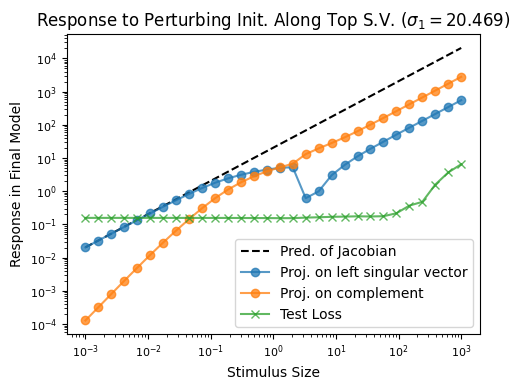

In [37]:
complements = []
bulk_y = []
responses = []

num = 0
grid = jnp.logspace(-3, 3, 30)
for stim in grid:
    perturbed_params, loss = train(
        params_0 + stim * jac_vh[num], X_train, Y_train, X_test, Y_test, apply_fn, TrainConfig(opt="sgd")
    )
    delta = perturbed_params - params_f
    res = delta @ jac_u[:, num]
    complement = jnp.linalg.norm(delta - res * jac_u[:, num])

    complements.append(complement)
    bulk_y.append(loss)
    responses.append(res)

plt.figure(figsize=(5, 4))  # Adjust figure size to be more paper-friendly
plt.plot(grid, grid * jac_s[num], label="Pred. of Jacobian", c="black", linestyle="--")
plt.plot(grid, jnp.abs(jnp.array(responses)), marker="o", label="Proj. on left singular vector", alpha=0.75)
plt.plot(grid, complements, marker="o", label="Proj. on complement", alpha=0.75)
plt.plot(grid, bulk_y, marker="x", label="Test Loss", alpha=0.75)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Stimulus Size")
plt.ylabel("Response in Final Model")
plt.title(f"Response to Perturbing Init. Along Top S.V. ($\\sigma_1 = {jac_s[0]:.3f}$)")
plt.legend()

# Tight layout to ensure no clipping
plt.tight_layout()

# Show or save the plot
plt.savefig('top sv perturb.pdf', format='pdf')
plt.show()

## Restricted training

In [30]:
anti_losses = []
bulk_losses = []

chaotic_losses = []
stable_losses = []

ks = jnp.linspace(100, len(params_0), 20).astype(int)
for k in ks:
    indices = jnp.argsort(jnp.abs(jac_s - 1))
    anti_bulk = indices[-k:]
    bulk = indices[:k]

    p = jnp.zeros(k)

    # Anti-bulk
    subspace_fn = make_apply_subspace(model, unravel, params_0, jac_vh[anti_bulk])
    _, anti_loss = train(p, X_train, Y_train, X_test, Y_test, subspace_fn, TrainConfig(opt="sgd"))
    anti_losses.append(anti_loss)

    # Bulk
    subspace_fn = make_apply_subspace(model, unravel, params_0, jac_vh[bulk])
    _, loss = train(p, X_train, Y_train, X_test, Y_test, subspace_fn, TrainConfig(opt="sgd"))
    bulk_losses.append(loss)

    # Chaotic
    subspace_fn = make_apply_subspace(model, unravel, params_0, jac_vh[:k])
    _, loss = train(p, X_train, Y_train, X_test, Y_test, subspace_fn, TrainConfig(opt="sgd"))
    chaotic_losses.append(loss)

    # Stable
    subspace_fn = make_apply_subspace(model, unravel, params_0, jac_vh[-k:])
    _, loss = train(p, X_train, Y_train, X_test, Y_test, subspace_fn, TrainConfig(opt="sgd"))
    stable_losses.append(loss)

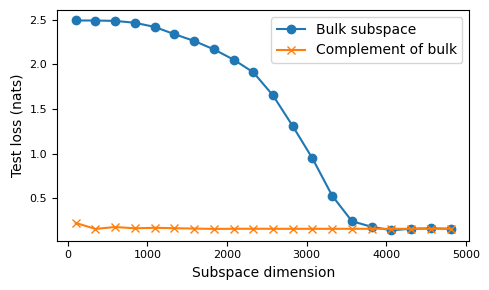

In [31]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 3))
plt.plot(ks, bulk_losses, marker="o", label="Bulk subspace")
plt.plot(ks, anti_losses, marker="x", label="Complement of bulk")
plt.xlabel("Subspace dimension")
plt.ylabel("Test loss (nats)")
plt.legend()

plt.tight_layout()
plt.savefig("subspace losses.pdf", format="pdf")

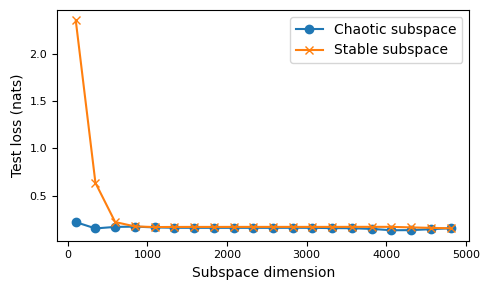

In [38]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 3))
plt.plot(ks, chaotic_losses, marker="o", label="Chaotic subspace")
plt.plot(ks, stable_losses, marker="x", label="Stable subspace")
plt.xlabel("Subspace dimension")
plt.ylabel("Test loss (nats)")
plt.legend()

plt.tight_layout()
plt.savefig("subspace losses2.pdf", format="pdf")

## Training on different distributions

In [33]:
key2 = jax.random.key(1)
Y_shuffled = jax.random.permutation(key2, Y_train)
X_noise = jax.random.uniform(key2, X_train.shape)

jac_shuffled, losses_shuffled = jac_fn(params_0, X_train, Y_shuffled, X_test, Y_test, apply_fn, TrainConfig(opt="sgd"))
jac_noise, losses_noise = jac_fn(params_0, X_noise, Y_train, X_test, Y_test, apply_fn, TrainConfig(opt="sgd"))

In [34]:
u_shuffled, s_shuffled, vh_shuffled = jnp.linalg.svd(jac_shuffled)
u_noise, s_noise, vh_noise = jnp.linalg.svd(jac_noise)

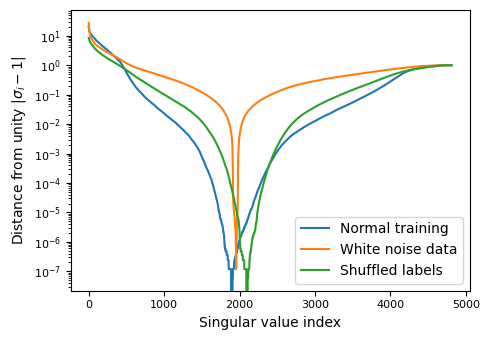

In [40]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 3.5))
plt.plot(jnp.abs(jac_s - 1), label="Normal training")
plt.plot(jnp.abs(s_noise - 1), label="White noise data")
plt.plot(jnp.abs(s_shuffled - 1), label="Shuffled labels")
plt.xlabel("Singular value index")
plt.ylabel("Distance from unity $|\\sigma_i - 1|$")
plt.yscale("log")
plt.legend()

plt.tight_layout()
plt.savefig('noise bird.pdf', format='pdf')

## Perturbations

In [4]:
def get_delta(cfg, basis = None, return_jac: bool = True):
    if basis is not None:
        apply_fn = make_apply_subspace(model, unravel, params_0, basis)
        params0 = jnp.zeros(len(basis))
    else:
        apply_fn = make_apply_full(model, unravel)
        params0 = params_0

    params_f, _ = train(params0, X_train, Y_train, X_test, Y_test, apply_fn, cfg)
    if return_jac:
        jac, _ = jac_fn(params0, X_train, Y_train, X_test, Y_test, apply_fn, cfg)
        jac_svd = jnp.linalg.svd(jac)
    else:
        jac_svd = None

    return params0, params_f, jac_svd, apply_fn

params0, params_f, jac_svd, apply_fn = get_delta(TrainConfig())

In [5]:
X_fake = jax.random.normal(jax.random.key(0), (len(X_test), 64))
X_inverted = 1 - X_test

In [6]:
import optax

perturbed = jax.vmap(apply_fn, in_axes=(0, None))(params_f + jac_svd.Vh, X_inverted)
original = apply_fn(params_f, X_inverted)

all_kls = optax.kl_divergence(jax.nn.log_softmax(perturbed), jax.nn.softmax(original))
inverted_kls = all_kls.max(axis=-1)

perturbed = jax.vmap(apply_fn, in_axes=(0, None))(params_f + jac_svd.Vh, X_fake)
original = apply_fn(params_f, X_fake)

all_kls = optax.kl_divergence(jax.nn.log_softmax(perturbed), jax.nn.softmax(original))
fake_kls = all_kls.max(axis=-1)

perturbed = jax.vmap(apply_fn, in_axes=(0, None))(params_f + jac_svd.Vh, X_train)
original = apply_fn(params_f, X_train)

all_kls = optax.kl_divergence(jax.nn.log_softmax(perturbed), jax.nn.softmax(original))
train_kls = all_kls.max(axis=-1)

perturbed = jax.vmap(apply_fn, in_axes=(0, None))(params_f + jac_svd.Vh, X_test)
original = apply_fn(params_f, X_test)

all_kls = optax.kl_divergence(jax.nn.log_softmax(perturbed), jax.nn.softmax(original))
test_kls = all_kls.max(axis=-1)

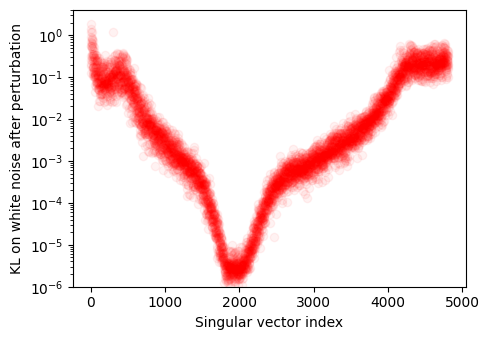

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 3.5))  # Adjust figure size to be more paper-friendly
plt.scatter(jnp.arange(len(train_kls)), train_kls, alpha=0.05, label="sqrt(train KL)", c="red")
plt.yscale("log")
plt.xlabel("Singular vector index")
plt.ylabel("KL on white noise after perturbation")
plt.ylim(1e-6, 4)

plt.tight_layout()

plt.savefig('kl bird.pdf', format='pdf')

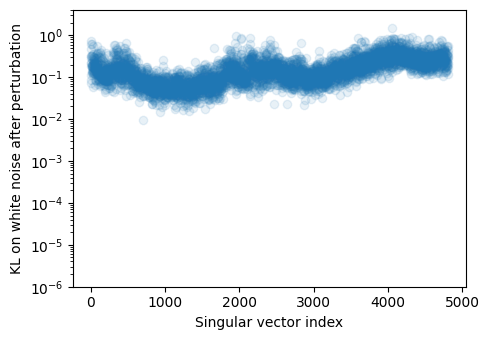

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 3.5))  # Adjust figure size to be more paper-friendly
plt.scatter(jnp.arange(len(fake_kls)), jnp.abs(fake_kls), alpha=0.1, label="test KL")
plt.yscale("log")
plt.xlabel("Singular vector index")
plt.ylabel("KL on white noise after perturbation")
plt.ylim(1e-6, 4)

plt.tight_layout()

plt.savefig('kl random.pdf', format='pdf')

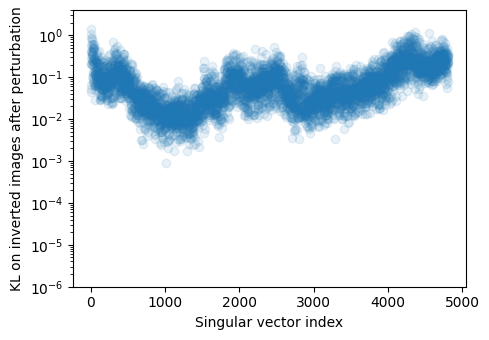

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 3.5))  # Adjust figure size to be more paper-friendly
plt.scatter(jnp.arange(len(inverted_kls)), jnp.abs(inverted_kls), alpha=0.1, label="test KL")
plt.yscale("log")
plt.xlabel("Singular vector index")
plt.ylabel("KL on inverted images after perturbation")
plt.ylim(1e-6, 4)

plt.tight_layout()

plt.savefig('kl inverted.pdf', format='pdf')

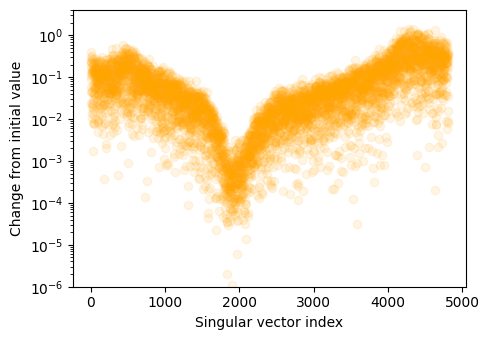

In [15]:
import matplotlib.pyplot as plt

deltas = jac_svd.Vh @ (params_f - params0)

plt.figure(figsize=(5, 3.5))  # Adjust figure size to be more paper-friendly
plt.scatter(jnp.arange(len(deltas)), jnp.abs(deltas), alpha=0.1, label="test KL", color="orange")
plt.yscale("log")
plt.xlabel("Singular vector index")
plt.ylabel("Change from initial value")
plt.ylim(1e-6, 4)

plt.tight_layout()

plt.savefig('deltas.pdf', format='pdf')